# Filecoin Baseline Crossing Data & Model

Notebook for data analytics and simulations regarding Filecoin Baseline Function & associated metrics like rewards and share of the world storage


Authors:
- Danilo Lessa Bernardineli (danilo@block.science)
- Gabriel Lefundes (gabriel@block.science)

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 8.57 ms (started: 2021-04-30 11:56:06 -03:00)


In [2]:
# External dependences
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Move path to parent folder
import sys
sys.path.insert(1, '../')

import plotly
plotly.offline.init_notebook_mode()

time: 1.61 s (started: 2021-04-30 11:56:06 -03:00)


## Data Analytics

In [3]:
NETWORK_LAUNCH = '2020-08-24 22:00+00:00'
MAINNET_LAUNCH = '2020-10-15 14:44+00:00'
BASELINE_CROSSING = '2021-04-02 05:00+00'

FIL_ISSUANCE = 2 * 1e9 # FIL
FIL_BASE = 0.55 * FIL_ISSUANCE # FIL
SIMPLE_FRACTION = 0.3
SIMPLE_ISSUANCE = SIMPLE_FRACTION * FIL_BASE
BASELINE_ISSUANCE = (1 - SIMPLE_FRACTION) * FIL_BASE

time: 13.6 ms (started: 2021-04-30 11:56:08 -03:00)


In [4]:
# Create a connection object from a conn string
from filecoin_metrics.connection import get_connection, get_connection_string
conn_string = get_connection_string('../config/sentinel-conn-string.txt')
connection = get_connection(conn_string)

time: 2.8 s (started: 2021-04-30 11:56:08 -03:00)


In [5]:
QUERY = f"""
select
	date_trunc('HOUR', to_timestamp(height_to_unix(cr.height))) as timestamp,
	date_trunc('HOUR', to_timestamp(height_to_unix(avg(cr.effective_network_time)::int8))) as effective_network_time,
	avg(cr.new_baseline_power::numeric / 1024^5) as baseline_power, /* PiB */
	avg(cp.total_raw_bytes_power::numeric / 1024^5) as raw_bytes_network_power, /* PiB */
	avg(cr.total_mined_reward::numeric / 1e18) as total_mined_reward /* FIL */
FROM chain_rewards cr
join chain_powers cp on cp.height = cr.height
where cr.height > 148888 /* Mainnet Launch Block Height */
group by timestamp
"""

query_df = (pd.read_sql(QUERY, connection))

time: 4.63 s (started: 2021-04-30 11:56:10 -03:00)


In [6]:
df = (query_df.copy())


time: 25.2 ms (started: 2021-04-30 11:56:15 -03:00)


In [7]:
fig = px.line(df,
              x='timestamp',
              y=['baseline_power', 'raw_bytes_network_power'],
              title='Baseline Power (PiB) vs RB Network Power (PiB)',
              labels={'value': 'RB Storage Power (PiB)',
                      'timestamp': 'Timestamp'})

fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text='Baseline Crossing')

# fig.add_vrect(NETWORK_LAUNCH, 
#               MAINNET_LAUNCH, 
#               fillcolor='green', 
#               opacity=0.15)

fig.show()

time: 608 ms (started: 2021-04-30 11:56:15 -03:00)


In [8]:
crossing_ind = np.argmin(np.abs(df.baseline_power - df.raw_bytes_network_power))
print(f"Baseline crossed at {df.iloc[crossing_ind].timestamp}")

Baseline crossed at 2021-04-02 05:00:00+00:00
time: 33.4 ms (started: 2021-04-30 11:56:16 -03:00)


In [9]:
y = (df.timestamp - df.effective_network_time).dt.days
fig = px.line(df,
              x='timestamp',
              y=y,
              title='Discrepancy Between Effective Network Time and Real Time',
              labels={'y': 'Difference in Days from Effective Network Time'})


fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text='Baseline Crossing')


# fig.add_vrect(NETWORK_LAUNCH, 
#               MAINNET_LAUNCH, 
#               fillcolor='green', 
#               opacity=0.15)

fig.show()

time: 314 ms (started: 2021-04-30 11:56:16 -03:00)


In [10]:
def rewards(t,
            t_0,
            issuance):
    dt_seconds = (t - t_0).total_seconds()
    dt = dt_seconds / (60 * 60 * 24 * 365.25) # Years
    lamb = np.log(2) / 6
    rewards = issuance * (1 - np.exp(-lamb * dt))
    return rewards

f = lambda x: rewards(x, pd.Timestamp(NETWORK_LAUNCH), SIMPLE_ISSUANCE)
g = lambda x: rewards(x, pd.Timestamp(NETWORK_LAUNCH), BASELINE_ISSUANCE)
h = lambda df: df.simple_rewards + df.baseline_rewards
k = lambda df: df.total_mined_reward - df.expected_rewards
df = (df.assign(simple_rewards=df.timestamp.map(f),
                baseline_rewards=df.effective_network_time.map(g))
        .assign(expected_rewards=h)
        .assign(rewards_error=k)
        .assign(simple_fraction=lambda df: df.simple_rewards / df.expected_rewards,
                baseline_fraction=lambda df: df.baseline_rewards / df.expected_rewards)
        .assign(hourly_simple_rewards=lambda df: df.simple_rewards.diff(),
                hourly_baseline_rewards=lambda df: df.baseline_rewards.diff())
     )

time: 45.4 ms (started: 2021-04-30 11:56:16 -03:00)


In [11]:
fig = px.line(df,
              x='timestamp',
              y=['simple_rewards', 'baseline_rewards'],
              title='Total Rewards over Time according to Minting Function')

fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text='Baseline Crossing')


# fig.add_vrect(NETWORK_LAUNCH, 
#               MAINNET_LAUNCH, 
#               fillcolor='green', 
#               opacity=0.15)
print("Total distributed rewards")
print(f"Simple: {df.simple_rewards.max() :.3g} FIL")
print(f"Baseline: {df.baseline_rewards.max() :.3g} FIL")
print(f"Total: {df.expected_rewards.max() :.3g} FIL")

fig.show()

Total distributed rewards
Simple: 2.5e+07 FIL
Baseline: 3.62e+07 FIL
Total: 6.12e+07 FIL


time: 690 ms (started: 2021-04-30 11:56:16 -03:00)


In [12]:
fig = px.line(df,
              x='timestamp',
              y=['simple_fraction', 'baseline_fraction'],
              title='Total Rewards over Time according to Minting Function (relative)')

fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text='Baseline Crossing')


# fig.add_vrect(NETWORK_LAUNCH, 
#               MAINNET_LAUNCH, 
#               fillcolor='green', 
#               opacity=0.15)
fig.add_hline(0.3, annotation_text='Long-Term Expected Simple Issuance Fraction')
fig.show()

time: 700 ms (started: 2021-04-30 11:56:17 -03:00)


## Modelling

On the following block, we'll build a cadCAD model for the Filecoin Minting Function

In [13]:
import numpy as np

SIMULATION_YEARS = 6
TIMESTEPS_PER_YEAR = 365
N_t = SIMULATION_YEARS * TIMESTEPS_PER_YEAR


## Logic

def years_passed(p, s, h, v, p_i):
    timesteps = v['timestep']
    years_per_timestep = p['years_per_timestep']
    return ('years_passed', timesteps * years_per_timestep)


def network_power(p, s, h, v, p_i):
    t = v['timestep']
    value = p['network_power_signal'][t]
    return ('network_power', value)


def baseline_function(p, s, h, v, p_i):
    b = (1 + p['baseline_growth_rate'])
    b **= v['years_passed']
    b *= p['initial_baseline']
    return ('baseline_function', b)


def cummulative_baseline_function(p, s, h, v, p_i):
    dt = p['years_per_timestep']
    value = min(v['network_power'], v['baseline_function']) * dt
    value += v['cummulative_baseline_function']
    return ('cummulative_baseline_function', value)


def effective_years_passed(p, s, h, v, p_i):
    g = np.log(1 + p['baseline_growth_rate'])
    
    R_sigma = v['cummulative_baseline_function']
    
    theta = np.log(1 + g * R_sigma / p['initial_baseline']) / g
    
    return ('effective_years_passed', theta)


def simple_block_reward(p, s, h, v, p_i):
    t = v['years_passed']
    value = p['simple_issuance'] * (1 - np.exp(-p['halving_rate'] * t))
    return ('simple_block_reward', value)


def baseline_block_reward(p, s, h, v, p_i):
    t = v['effective_years_passed']
    value = p['baseline_issuance'] * (1 - np.exp(-p['halving_rate'] * t))
    return ('baseline_block_reward', value)


def block_reward(p, s, h, v, p_i):
    value = v['baseline_block_reward'] + v['simple_block_reward']
    return ('block_reward', value)

## Structure

partial_state_update_blocks = [
    {
        'policies': {
            
        },
        'variables': {
            'years_passed': years_passed
        }
    },
    {
        'policies': {
            
        }, 
        'variables': {
            'baseline_function': baseline_function,
            'network_power': network_power
        }
        
    },
    {
        'policies': {
            
        },
        'variables': {
            'cummulative_baseline_function': cummulative_baseline_function
        }
    },
    {
        'policies': {
            
        },
        'variables': {
            'effective_years_passed': effective_years_passed
        }
    },
    {
    'policies': {

    },
    'variables': {
        'simple_block_reward': simple_block_reward,
        'baseline_block_reward': baseline_block_reward,
    }
},
        {
    'policies': {

    },
    'variables': {
        'block_reward': block_reward
    }
}
]

time: 27.1 ms (started: 2021-04-30 11:56:18 -03:00)


In [14]:
START_NP = 500
END_NP = 10000

NP_1 = np.linspace(START_NP, END_NP, int(2 * N_t / 10))
NP_2 = END_NP * np.ones(int(8 * N_t / 10) + 1)
NP = np.concatenate([NP_1, NP_2])

time: 34.2 ms (started: 2021-04-30 11:56:18 -03:00)


In [15]:
## Params


HALVING_PERIOD = 6 # Years

# N_t: number of timesteps
params = {
    
    # Input Signals
    'network_power_signal': [NP], # PiB
    
    # Parameters
    'initial_baseline': [2888], # PiB
    'baseline_growth_rate': [1.0], # Percent per year
    'simple_issuance': [0.3], # FIL
    'baseline_issuance': [0.7], # FIL
    'halving_rate': [np.log(2) / HALVING_PERIOD], # Years
    
    # Unit conversion
    'years_per_timestep': [1 / TIMESTEPS_PER_YEAR],
    
}

## Initial Conditions

initial_conditions = {
    'years_passed': 0,
    'network_power': None,
    'baseline_function': None,
    'cummulative_baseline_function': 0,
    'effective_years_passed': 0,
    'simple_block_reward': 0,
    'baseline_block_reward': 0,
    'block_reward': 0
}

time: 29.9 ms (started: 2021-04-30 11:56:18 -03:00)


In [16]:
%%capture
from cadCAD_tools import easy_run

sim_df = easy_run(initial_conditions,
              params,
              partial_state_update_blocks,
              N_t,
              1,
              assign_params=True,
              drop_substeps=True)

time: 1.18 s (started: 2021-04-30 11:56:18 -03:00)


In [17]:
sim_df.head(5)

years_passed  network_power  baseline_function  \
0       0.000000            NaN                NaN   
6       0.000000     521.739130        2888.000000   
12      0.002740     543.478261        2893.489619   
18      0.005479     565.217391        2898.989673   
24      0.008219     586.956522        2904.500182   

    cummulative_baseline_function  effective_years_passed  \
0                        0.000000                0.000000   
6                        1.429422                0.000495   
12                       2.918404                0.001010   
18                       4.466945                0.001546   
24                       6.075045                0.002102   

    simple_block_reward  baseline_block_reward  block_reward  simulation  \
0              0.000000               0.000000      0.000000           0   
6              0.000000               0.000040      0.000040           0   
12             0.000095               0.000082      0.000177           0   
18             0.000190               0.000125      0.000315           0   
24             0.000285               0.000170      0.000455           0   

    subset  run  timestep  network_power_signal  initial_baseline  \
0        0    1         0            500.000000              2888   
6        0    1         1            521.739130              2888   
12       0    1         2            543.478261              2888   
18       0    1         3            565.217391              2888   
24       0    1         4            586.956522              2888   

    baseline_growth_rate  simple_issuance  baseline_issuance  halving_rate  \
0                    1.0              0.3                0.7      0.115525   
6                    1.0              0.3                0.7      0.115525   
12                   1.0              0.3                0.7      0.115525   
18                   1.0              0.3                0.7      0.115525   
24                   1.0              0.3                0.7      0.115525   

    years_per_timestep  
0              0.00274  
6              0.00274  
12             0.00274  
18             0.00274  
24             0.00274

time: 47.1 ms (started: 2021-04-30 11:56:19 -03:00)


In [18]:
fig_df = sim_df.query('years_passed < 2.5 & years_passed > 0.0')

x = fig_df.years_passed

fig = make_subplots(rows=1, 
                    cols=3,
                    shared_xaxes=True,
                    x_title='Years Passed Since Mainnet',
                    subplot_titles=['Network Power vs Baseline Function',
                                    'Instantaneous Share of Baseline Rewards',
                                    'Effective Network Time Lag'])

fig.add_trace(
    go.Scatter(x=x,
               y=fig_df.network_power,
               name='RB Network Power (PiB)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x,
               y=fig_df.baseline_function,
               name='Baseline Function (PiB)'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x,
               y=fig_df.baseline_block_reward.diff() / fig_df.block_reward.diff(),
               name='Baseline Reward Fraction'),
    row=1, col=2
)


fig.add_trace(
    go.Scatter(x=x,
               y=fig_df.years_passed - fig_df.effective_years_passed,
               name='Lag (Years)'),
    row=1, col=3
)

# Plot Baseline Crossings

# Find roots
from scipy import interpolate
from scipy.optimize import fsolve

x = fig_df.years_passed
y = fig_df.baseline_function - fig_df.network_power
f = f = interpolate.interp1d(x, y)
roots = fsolve(f, [0.1, 2.1])

# Visualize Baseline Crossings lines
for root in roots:
    fig.add_vline(root, 
                  line_color='green',
                  annotation_text='Baseline Crossing',
                  annotation_textangle=-90,
                  annotation_yanchor='top')


fig.update_layout(title_text="Behaviour When Crossing Baseline Funtion",
                  width=1600,
                  height=600)
fig.show()

time: 435 ms (started: 2021-04-30 11:56:19 -03:00)


In [19]:
T_0 = pd.Timestamp(MAINNET_LAUNCH)
f = lambda df: T_0 + df.years_passed.map(lambda x: pd.Timedelta(x * 365.25, unit='day'))

sim_df = sim_df.assign(timestamp=f)

time: 50.8 ms (started: 2021-04-30 11:56:19 -03:00)


In [20]:
fig = px.line(sim_df,
              x='timestamp',
              y=sim_df.baseline_function / 1024,
              title='Projected Baseline Function for the next 6 years',
              labels={'y': 'Storage in EiB'})

fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text="Baseline Crossing")
fig.show()

time: 196 ms (started: 2021-04-30 11:56:19 -03:00)


In [21]:
ZiB = 1024 ** 2

cols = ('timestamp', 'data_sphere_size', 'core_store_fraction')

DATA_SPHERE_RECORDS = [
    ('2020-07-01 00:00+00:00', 50 * ZiB, 0.28),
    ('2021-07-01 00:00+00:00', 65 * ZiB, 0.33),
    ('2022-07-01 00:00+00:00', 80 * ZiB, 0.38),
    ('2023-07-01 00:00+00:00', 102 * ZiB, 0.42),
    ('2024-07-01 00:00+00:00', 130 * ZiB, 0.45),
    ('2025-07-01 00:00+00:00', 175 * ZiB, 0.48),
    ('2026-07-01 00:00+00:00', 190 * ZiB, 0.50)
]

ds_df = (pd.DataFrame.from_records(DATA_SPHERE_RECORDS, columns=cols)
           .assign(core_store_size=lambda df: df.data_sphere_size * df.core_store_fraction))

time: 52.1 ms (started: 2021-04-30 11:56:20 -03:00)


In [22]:
z_df = (pd.concat([ds_df, sim_df])
          .assign(timestamp=lambda df: pd.to_datetime(df.timestamp, utc=True))
          .sort_values('timestamp')
          .assign(core_store_size=lambda df: df.core_store_size.interpolate())
          .assign(baseline_vs_world=lambda df: df.baseline_function / df.core_store_size))

time: 58.8 ms (started: 2021-04-30 11:56:20 -03:00)


In [23]:
px.line(z_df,
           x='timestamp',
           y=['core_store_size', 'baseline_function'],
           labels={'value': 'PiB'},
           log_y=True)

time: 392 ms (started: 2021-04-30 11:56:20 -03:00)


In [24]:
fig = px.line(z_df,
              x='timestamp',
              y='baseline_vs_world',
              title='Baseline Function Growth in terms of the Projected World Storage (Public Cloud)',
              labels={'baseline_vs_world': 'Baseline as fraction of the World Storage'})

fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text="Baseline Crossing")
              
fig.layout.yaxis.tickformat = ',.2%'
fig.show()

time: 267 ms (started: 2021-04-30 11:56:20 -03:00)


In [25]:
WORLD_MAX_CAPACITY = 50000

proj_df = (df.resample('1w', on='timestamp')
             .mean()
             .reset_index()
             .assign(ds=lambda df: df.timestamp.dt.tz_localize(None))
             .assign(y=lambda df: df.raw_bytes_network_power)
             .assign(cap=WORLD_MAX_CAPACITY))

m = Prophet(growth = 'logistic')
m.fit(proj_df)
future = m.make_future_dataframe(periods=180)
future['cap'] = WORLD_MAX_CAPACITY
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.


time: 5.88 s (started: 2021-04-30 11:56:20 -03:00)


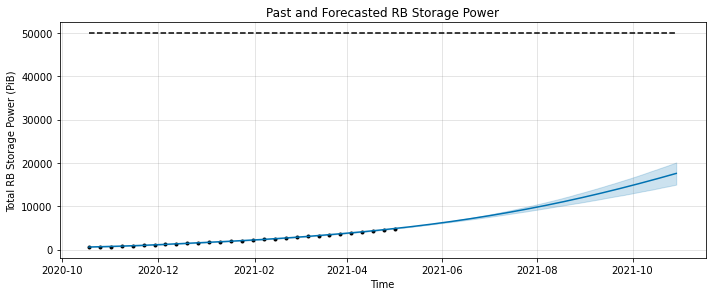

time: 242 ms (started: 2021-04-30 11:56:26 -03:00)


In [26]:
fig = m.plot(forecast, figsize=(10, 4))
plt.title('Past and Forecasted RB Storage Power')
plt.xlabel("Time")
plt.ylabel("Total RB Storage Power (PiB)")
plt.show()

In [27]:
f = lambda df: df.ds

f_df = pd.concat([forecast.assign(timestamp=f), z_df])

time: 37.4 ms (started: 2021-04-30 11:56:27 -03:00)


In [28]:
x = forecast.ds
x_rev = x[::-1]
y = forecast.yhat
y_upper = forecast.yhat_upper
y_lower = forecast.yhat_lower
y_lower_rev = y_lower[::-1]


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, 
    y=y,
    line_color='rgb(0,176,246)',
    name='RB Network Power',
))

fig.add_trace(go.Scatter(
    x=pd.concat([x, x_rev]),
    y=pd.concat([y_upper, y_lower_rev]),
    fill='toself',
    name='RB Network Power (uncertainty)',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
))

fig.add_trace(go.Scatter(
    x=z_df.timestamp, 
    y=z_df.baseline_function,
    name='Baseline Function',
    line_color='coral',
))
fig.update_layout(title='Projection of RB Network Power vs Baseline Function',
                    yaxis_title='Storage (PiB)',
                    xaxis_title='Timestamp')
fig.update_traces(mode='lines')
fig.add_vline(pd.Timestamp(BASELINE_CROSSING).timestamp() * 1000,
              annotation_text="Baseline Crossing")
fig.show()

time: 206 ms (started: 2021-04-30 11:56:27 -03:00)


In [29]:
t = 1
g_0 = 1
(np.log((1 + g_0) ** t + 1) + np.log(1 / 2)) / np.log(1 + g_0)

0.5849625007211564

time: 25.6 ms (started: 2021-04-30 11:56:27 -03:00)


In [30]:
t = 0
(np.log(2 ** t + 1) + np.log(1 / 2)) / np.log(2)

0.0

time: 24.3 ms (started: 2021-04-30 11:56:27 -03:00)


In [31]:
np.log(1/2) / np.log(2)

-1.0

time: 26.8 ms (started: 2021-04-30 11:56:27 -03:00)


In [32]:
1 / np.log(2)

1.4426950408889634

time: 29.9 ms (started: 2021-04-30 11:56:27 -03:00)


In [33]:
theta = lambda t: np.log(2 ** t + 1) - 1

t = np.linspace(0, 10, 100)
dt = 0.01
y = (theta(t + dt) - theta(t)) / dt
px.line(x=t,
        y=y,
        title="Effective Network Power as Fraction of Real Time (RB-NP = 50% Baseline)",
        labels={'x': 'Years Passed',
                'y': 'Fraction of Real Time'})

time: 82.6 ms (started: 2021-04-30 11:56:27 -03:00)
